# Example analysis: Simple differential expression analysis between B-Cells and T-Lymphocytes

README: Run this notebook trying to see how we can use the unified metadata and the reprocessed RNAseq data to extract thousands of reprocessed sequening runs to generate publication-ready figures in <1 minute. 

### Input: Query

### Feel free to change the query in the cell below and see what happens, the query is the class label to regular expression query dictionary. 

Input: {"user-defined class labels":"Regular expression to match in meta data" }

Output: Matrix with fully annotated columns

`ls /home/jovyan/efs/all_seq/rnaseq_merged/` to see all available species


In [1]:
"""
"""
queryLabelToRegexDict={"B-Cell":'B-Cell|B-Lymphocyte',"T-Lymphocyte":'T-Lymphocyte|T-Cell',
                      # 'Liver':'Hepatocyte|Liver' #uncomment this line to see changes
                      }

querySpecie='Homo_sapiens' #Check files in baseDir directory for more species

# Data loading

### load in SRS biospecieman annotations

In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np

allSRS_pickle_dir='/home/jovyan/efs/all_seq/meta_data/allSRS.with_processed_data.pickle.gz'
%time allSRS=pd.read_pickle(allSRS_pickle_dir)
allSRS.index.names=['SRS','Attrib']

CPU times: user 5.63 s, sys: 464 ms, total: 6.09 s
Wall time: 6.09 s


### load in technical metadata

In [3]:
sra_dump_pickle_dir='/home/jovyan/efs/all_seq/meta_data/sra_dump.fastqc.bowtie_algn.pickle'
%time technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)
technical_meta_data_df[('SRAmeta','Run')]=technical_meta_data_df.index

CPU times: user 4 s, sys: 1.34 s, total: 5.33 s
Wall time: 5.34 s


### load the expression matrix

Check files in baseDir directory for more species

In [4]:
def loadDf(fname,mmap_mode='r'):
    with open(fname+'.index.txt') as f:
        myIndex=map(lambda s:s.replace("\n",""), f.readlines())
    with open(fname+'.columns.txt') as f:
        myColumns=map(lambda s:s.replace("\n",""), f.readlines())
    tmpMatrix=np.load(fname+".npy",mmap_mode=mmap_mode)
    tmpDf=pd.DataFrame(tmpMatrix,index=myIndex,columns=myColumns)
    tmpDf.columns.name='Run'
    return tmpDf
baseDir='/home/jovyan/efs/all_seq/rnaseq_merged/' #Base directory
expression_metric='tpm' #offer Kallisto expression metric: ["tpm","est_counts"]
data_matrix_dir=baseDir+'/{specie}.gene_symbol.{expression_metric}'.format(specie=querySpecie,
                                            expression_metric=expression_metric)

%time rnaseqDf=loadDf(data_matrix_dir)

CPU times: user 132 ms, sys: 8 ms, total: 140 ms
Wall time: 162 ms


# Find the relevent SRS (Sample  IDs)  


In [5]:
myL=[]
for  queryRegex in queryLabelToRegexDict.values():
    %time hitSrsS=allSRS[allSRS.str.contains(queryRegex,case=False)]
    myL.append(hitSrsS)

queryLabel='queryLabel'
mergeS=pd.concat(myL,keys=queryLabelToRegexDict.keys(),names=[queryLabel])
mergeS_noDup=mergeS.groupby(['SRS','queryLabel','Attrib']).first()
unqiueHitMask=mergeS_noDup.groupby('SRS').size()==1
unqiueHitSrs=unqiueHitMask.index[unqiueHitMask]
mergeS_noDup_unique=mergeS_noDup[mergeS_noDup.index.get_level_values('SRS').isin(unqiueHitSrs)]

CPU times: user 4.28 s, sys: 112 ms, total: 4.4 s
Wall time: 3.8 s
CPU times: user 4.09 s, sys: 44 ms, total: 4.14 s
Wall time: 3.54 s


Number of SRS per query class

In [6]:
mergeS_noDup_unique.groupby(queryLabel).size()

queryLabel
B-Cell          1105
T-Lymphocyte    1060
dtype: int64

In [7]:
srsToClasses_all=mergeS_noDup_unique.reset_index().set_index(['SRS'])['queryLabel']

srsToClasses=srsToClasses_all

### map SRS Ids to SRR Ids

In [8]:
m_SRAMeta=technical_meta_data_df[('SRAmeta','Sample')].isin(srsToClasses.index)
technical_meta_data_df_hit=technical_meta_data_df[m_SRAMeta]

SRAMetasrsCorrespondingQuery=srsToClasses.loc[technical_meta_data_df_hit[('SRAmeta','Sample')]].values
technical_meta_data_df_hit[('SRAmeta',queryLabel)]=SRAMetasrsCorrespondingQuery
relevantMetaColsL=[('SRAmeta',queryLabel),('SRAmeta','Study'),('SRAmeta','Sample'),('SRAmeta','Run'),('SRAmeta','ScientificName')]
technical_meta_data_df_sub=technical_meta_data_df_hit[relevantMetaColsL]
designDf=technical_meta_data_df_sub['SRAmeta']

/opt/conda/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Top species with reprocessed data

In [9]:
designDf['ScientificName'].value_counts().head(n=5)

Homo_sapiens                      17564
Mus_musculus                        203
Geobacter_sulfurreducens_KN400        0
Geodermatophilus_aquaeductus          0
Geodermatophilus_amargosae            0
Name: ScientificName, dtype: int64

In [10]:
%time designDf_specie=designDf[(designDf['ScientificName']==querySpecie)&(designDf.Run.isin(rnaseqDf.columns))]
#designDf_subsampled=designDf_specie.sample(n=designDf_specie.shape[0]).groupby(queryLabel).head(n=2)
queryDesignDf=designDf_specie

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 36.7 ms


Number of samples per query class with data

In [11]:
designDf_specie.groupby(queryLabel).size()

queryLabel
B-Cell          459
T-Lymphocyte    904
dtype: int64

In [12]:
%time hitDf=pd.DataFrame( list(map( lambda srrId: rnaseqDf[srrId],queryDesignDf.Run))).T
hitDf.columns=queryDesignDf.set_index(queryDesignDf.columns.tolist()).index
#float16=2**6
#from numpy import inf
#hitDf.as_matrix()[hitDf.as_matrix()==inf]=float16

CPU times: user 1.96 s, sys: 244 ms, total: 2.2 s
Wall time: 2.2 s


### Output:  fully annnotated matrix matrix

Example layout is listed in the cell below

In [13]:
hitDf.head()

queryLabel           B-Cell                                         \
Study             SRP015715                 SRP045500                
Sample            SRS362251    SRS362252    SRS684342    SRS684323   
Run               SRR567561    SRR567562   SRR1551103   SRR1551084   
ScientificName Homo_sapiens Homo_sapiens Homo_sapiens Homo_sapiens   
TRDD2                   0.0          0.0          0.0          0.0   
TRDD1                   0.0          0.0          0.0          0.0   
TRDD3                   0.0          0.0          0.0          0.0   
IGHD4-17                0.0          0.0          0.0          0.0   
IGHD4-4                 0.0          0.0          0.0          0.0   

queryLabel                                                          \
Study             SRP077016                                          
Sample           SRS1523416   SRS1523415   SRS1523414   SRS1523413   
Run              SRR3714038   SRR3714037   SRR3714036   SRR3714035   
ScientificName Homo_sapiens Homo_sapiens Homo_sapiens Homo_sapiens   
TRDD2                   0.0          0.0          0.0          0.0   
TRDD1                   0.0          0.0          0.0          0.0   
TRDD3                   0.0          0.0          0.0          0.0   
IGHD4-17                0.0          0.0          0.0          0.0   
IGHD4-4                 0.0          0.0          0.0          0.0   

queryLabel                  T-Lymphocyte     ...                    \
Study             SRP072506    SRP075608     ...         SRP108237   
Sample           SRS1366402   SRS1464366     ...        SRS2237774   
Run              SRR3309374   SRR3579131     ...        SRR5626834   
ScientificName Homo_sapiens Homo_sapiens     ...      Homo_sapiens   
TRDD2                   0.0          0.0     ...               0.0   
TRDD1                   0.0          0.0     ...               0.0   
TRDD3                   0.0          0.0     ...               0.0   
IGHD4-17                0.0          0.0     ...               0.0   
IGHD4-4                 0.0          0.0     ...               0.0   

queryLabel           B-Cell              T-Lymphocyte               \
Study             SRP007461                 SRP019939                
Sample            SRS281643                 SRS403486                
Run               SRR768411    SRR768412    SRR791578    SRR791579   
ScientificName Homo_sapiens Homo_sapiens Homo_sapiens Homo_sapiens   
TRDD2                   0.0          0.0          0.0          0.0   
TRDD1                   0.0          0.0          0.0          0.0   
TRDD3                   0.0          0.0          0.0          0.0   
IGHD4-17                0.0          0.0          0.0          0.0   
IGHD4-4                 0.0          0.0          0.0          0.0   

queryLabel                                                          \
Study                                                                
Sample                         SRS403487    SRS403488                
Run               SRR791580    SRR791583    SRR791584    SRR791585   
ScientificName Homo_sapiens Homo_sapiens Homo_sapiens Homo_sapiens   
TRDD2                   0.0          0.0          0.0          0.0   
TRDD1                   0.0          0.0          0.0          0.0   
TRDD3                   0.0          0.0          0.0          0.0   
IGHD4-17                0.0          0.0          0.0          0.0   
IGHD4-4                 0.0          0.0          0.0          0.0   

queryLabel                   
Study                        
Sample                       
Run               SRR791586  
ScientificName Homo_sapiens  
TRDD2                   0.0  
TRDD1                   0.0  
TRDD3                   0.0  
IGHD4-17                0.0  
IGHD4-4                 0.0  

[5 rows x 1363 columns]

#  Example Analysis with output matrix


In [14]:
inputAnalyzeDf=np.log2(hitDf+1)

### PCA to show samples are grouped in the higher dimensional space

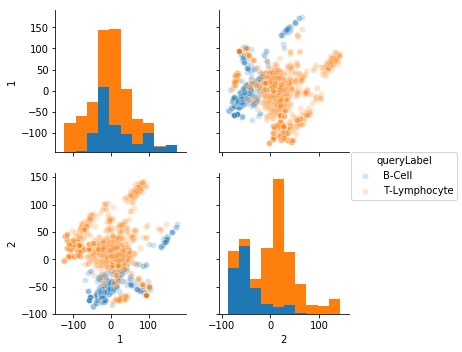

In [27]:

inPcaDf=inputAnalyzeDf.T
%matplotlib inline
from sklearn import decomposition
import seaborn as sns
PCA=decomposition.PCA(n_components=3)
pcaM=PCA.fit_transform((inPcaDf))
pcaDf=pd.DataFrame( data=pcaM,index=inPcaDf.index)
plotPcs=[1,2]
sns.pairplot(data=pcaDf.reset_index()[plotPcs+[queryLabel]],hue=queryLabel,plot_kws={'alpha':0.2})

### Volcano plot with t-test

In [16]:
from scipy import stats
import matplotlib.pyplot as plt

/opt/conda/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


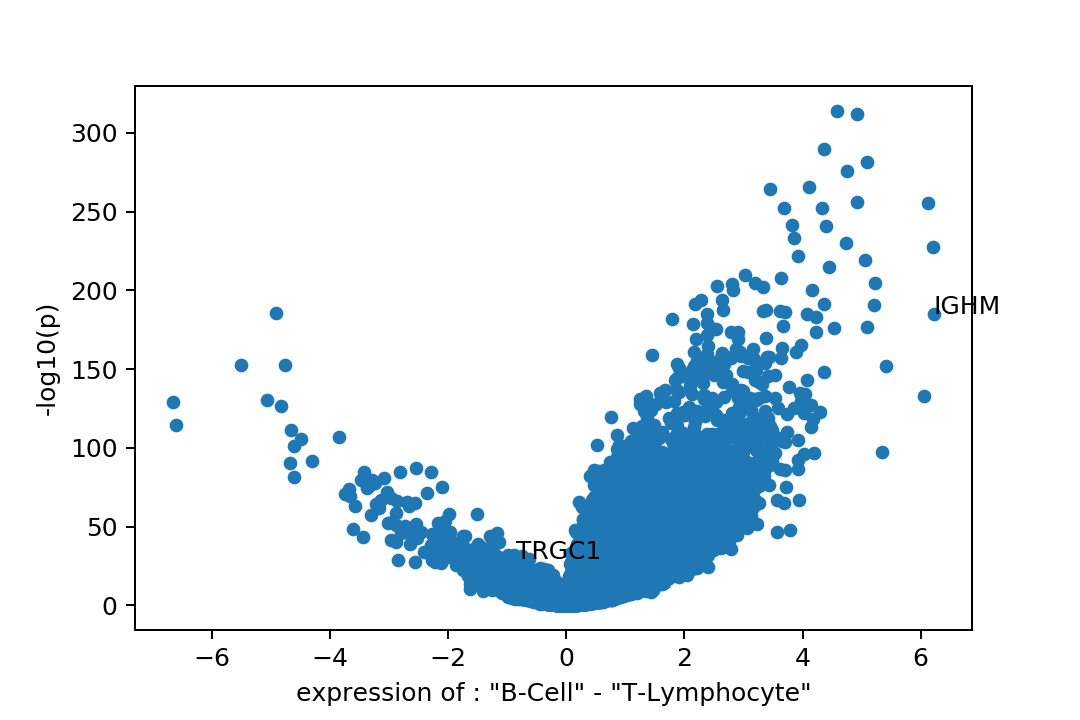

[]

In [36]:
%matplotlib notebook
labelA='B-Cell'
labelB='T-Lymphocyte'
annotateGenes=['TRGC1','IGHM']
t,p=stats.ttest_ind(inputAnalyzeDf[labelA],inputAnalyzeDf[labelB],axis=1)
effectDiff=inputAnalyzeDf[labelA].mean(axis=1)-inputAnalyzeDf[labelB].mean(axis=1)
effectLabel='expression of : "{}" - "{}"'.format(labelA, labelB)
tmpDf=pd.DataFrame({'t':t,'-log10(p)':-np.log10(p),effectLabel:effectDiff,'u':inputAnalyzeDf.mean(axis=1)},index=inputAnalyzeDf.index)
plotDf=tmpDf[tmpDf['u']>=0]
yLabel='-log10(p)'
xLabel=effectLabel
ax=plotDf.plot(x=xLabel,y=yLabel,kind='Scatter')
annotDf=plotDf.loc[annotateGenes]

for geneName, tmpS in annotDf.iterrows():
    ax.annotate(xy=(tmpS.loc[xLabel],tmpS.loc[yLabel]),text=geneName)
ax.plot()


In [18]:
rankS=tmpDf['-log10(p)'].fillna(1.0).sort_values().rank()/tmpDf.shape[0]

Unsurprisingly, the IGHM gene which encodes the constant region of the B-cell receptor are highly expressed in B-Cells when compared with T-Cells.


In [19]:
queryGene='IGHM'
upRegDf=tmpDf[tmpDf[effectLabel]>0]
rankOfGene=(upRegDf['-log10(p)'].rank()/upRegDf.shape[0]).loc[queryGene]*100
print ('{} is the top {}% expressed gene in {} '.format(queryGene,rankOfGene,labelA))

IGHM is the top 99.83116152214382% expressed gene in B-Cell 


Unsurprisingly, the TRGC1 gene which encodes the constant region of the T-Cell receptors are highly expressed in  T-Cells when compared with B-Cells.



In [20]:
queryGene='TRGC1'
downRegDf=tmpDf[tmpDf[effectLabel]<0]
rankOfGene=(downRegDf['-log10(p)'].rank()/downRegDf.shape[0]).loc[queryGene]*100
print ('{} is the top {}% expressed gene in {} '.format(queryGene,rankOfGene,labelB))

TRGC1 is the top 98.82454624027658% expressed gene in T-Lymphocyte 


### Study correlation heatmap

Useful for finding outliers

B-Cell            red
T-Lymphocyte    green
dtype: object


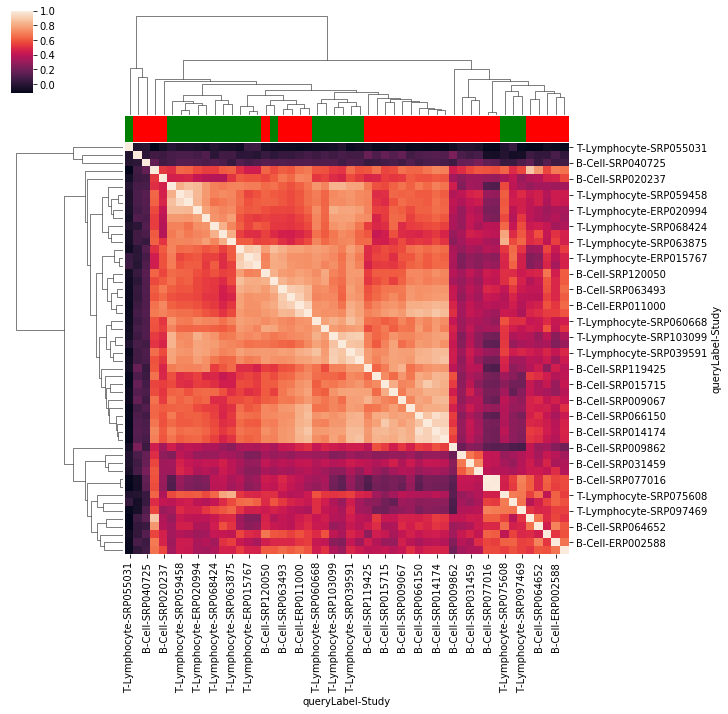

In [35]:
%matplotlib inline
myColorL=['red','green','blue'] ##add more colors as you see fit

sigDf=inputAnalyzeDf.groupby(level=['queryLabel','Study'],axis=1).mean()
corrDf=sigDf[sigDf.mad(axis=1)>np.log2(5)].corr()
corrDf_valid=corrDf.loc[~corrDf.isnull().all(axis=1),~corrDf.isnull().all(axis=0)]
labelToColorS=pd.Series(dict(zip(corrDf_valid.index.get_level_values('queryLabel').unique(),myColorL)))
print (labelToColorS)
colors=labelToColorS[corrDf_valid.index.get_level_values('queryLabel')].values
g=sns.clustermap(data=corrDf_valid,col_colors=colors,metric='euclidean')
g

# Caveats

### Caveat: the mode of expression from public sequencing data usually don't have same center, that's why the Volcano plot from above is skewed

You might want to do a median/mean center in your dataset

In [22]:
inputAnalyzeDf[labelA].mean(axis=1).median(),\
inputAnalyzeDf[labelB].mean(axis=1).median()

(0.35614014, 0.24869752)

### Caveat: Batch effect
If the first PC (PC0 in the following plot) does not seperate the  experimental condition, this is most likely due to batch effect. Sometimes plotting second and third PC like the above plot will find the seperation.

If it doesn't do the job, I recommend doing a simple z-score of the data to subtract out the covariates before going down the route of using batch correction tools like: [Combat, SVR](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0030161) or DEseq. 

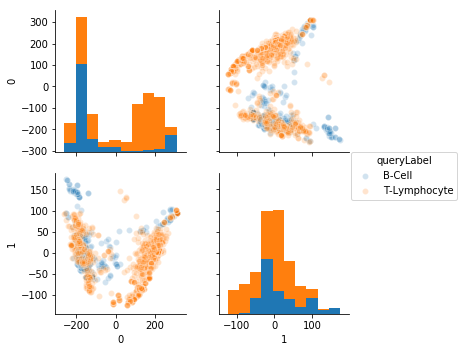

In [23]:
plotPcs=[0,1]
sns.pairplot(data=pcaDf.reset_index()[plotPcs+[queryLabel]],hue=queryLabel,plot_kws={'alpha':0.2})